In [2]:
import csv
import numpy as np
import math
import pandas as pd
from collections import deque
import copy

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# import matplotlib.animation as animation
import IPython

__requires__= 'networkx==2.5'
import networkx as nx
print("Networkx version: " + nx.__version__)

%matplotlib nbagg

Networkx version: 2.5


In [3]:
#plot parameters
figure_size=6
marker_size=figure_size*50

node_size=400
node_font_size=15

plt.rcParams['figure.figsize'] = figure_size, figure_size
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.ymargin'] = 0.05
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False


# Identifying Communities by Modularity Optimization

Communities in networks can be identified through the minimization of graph modularity.  In the following cells, an algorithm to find communities is implemented for a mock 2-dimensional system.  This is later applied to a 3D chemical system.


The mock 2D system is created as a "ring of rings".  Where pairs of smaller rings are adjusted to sit more adjacent to each other.  This data set is structured in this manner as to create communities of communities in order to properly demonstrated the iterative process of finding "super" communities within a graph.

<IPython.core.display.Javascript object>


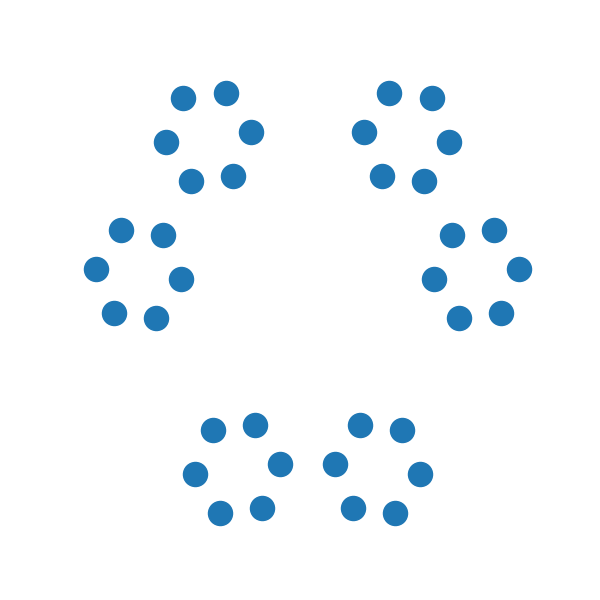

In [4]:
def create_2D_community(): 
    
    r_outer=2
    r_inner=8

    num_phi_outer=6
    num_phi_inner=6
    
    x=np.empty(0)
    y=np.empty(0)

    #create alternating sub cluster distances
    lamda=(2*np.pi)/(num_phi_inner) #wavelength
    A=.1 #magnitude

    phi_outer_array=np.arange(0, (2 * np.pi), 2*np.pi/num_phi_outer)
    phi_inner_array=np.arange(0, (2 * np.pi), 2*np.pi/num_phi_inner)
    phi_inner_array+=A*np.cos((phi_inner_array)*np.pi/lamda)

    for phi_outer in phi_outer_array:
        for phi_inner in phi_inner_array:

            x_outer=r_outer*np.cos(phi_outer)+r_inner
            y_outer=r_outer*np.sin(phi_outer)

            r=(x_outer**2+y_outer**2)**(0.5)
            phi=math.atan(y_outer/x_outer)+phi_inner

            x = np.append(x, r*np.cos(phi))
            y = np.append(y, r*np.sin(phi))
    return x,y


fig = plt.figure()
x_array,y_array = create_2D_community()
plt.scatter(x_array,y_array, s=marker_size)
plt.show()

# Graph of the 2D System

This function takes the xy data from the 2D system and a user defined distance criteria to create weighted graph.  The graph node attributes are the cartesian coordinates, node color, and a community ID initially set to the node number.  

The graph edges are created for node pairs within the distance criteria and are weighted as the inverse of the euclidean distance.  

In [215]:
#Create weighted graph based on geometric distance criteria
def create_primary_graph(x_array=[],y_array=[],z_array=[],distance_criteria=1.0): 
    
    graph = nx.Graph() 
    
    for i, x in enumerate(x_array):
        if z_array.any:
            graph.add_node(i,
                       coords = [float(x_array[i]), float(y_array[i]), float(z_array[i])],
                       community_ID = i,
                      )         
        else:
            graph.add_node(i,
                       coords = [float(x_array[i]), float(y_array[i])],
                       community_ID = i,
                      ) 

    #add graph edges based on distances
    #weight edges based on inverse distance
    for i, x in enumerate(x_array):
        for j, x in enumerate(x_array):
            if (i<j):
                if z_array.any:
                    xi, yi, zi = graph.nodes[i]['coords']
                    xj, yj, zj = graph.nodes[j]['coords']    
                    distance=np.sqrt((xi-xj)**2+(yi-yj)**2+(zi-zj)**2)
                else:
                    xi, yi = graph.nodes[i]['coords']
                    xj, yj = graph.nodes[j]['coords']    
                    distance = np.sqrt((xi-xj)**2+(yi-yj)**2)
                    
                if ( distance <= distance_criteria):
                    graph.add_edge(i,j,weight = 1/distance)
    
#     colorNodes(graph,'Spectral')
                    
    return graph

#Color graph nodes according to community ID
def colorNodes(graph: "networkx.classes.graph.Graph", color_map):
    #get Min and Max community_ID values to bound color gradient
    min=len(graph.nodes())
    max=0
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']<min:
            min=graph.nodes[node]['community_ID']
        if graph.nodes[node]['community_ID']>max:
            max=graph.nodes[node]['community_ID']
    gradientDistance=max-min
    for node in graph.nodes():
        graph.nodes[node]['color']=eval("cm." + color_map + "((graph.nodes[node]['community_ID']-min)/gradientDistance)")

    return graph


In [280]:
# plot graph using xy positions
def plot_communities(graph, ax, dim=2, alpha=1):
    
    if dim==3:
        ax = plt.axes(projection='3d')
        ax.set_axis_off()

    graph = colorNodes(graph,'Spectral')
    pos = nx.get_node_attributes(graph,'coords')
    edges_coords = np.array([(pos[u],pos[v]) for u, v in graph.edges])
    
    for edge_coord in edges_coords:
        ax.plot(*edge_coord.T, color="tab:gray", alpha=alpha)
        
    for node in graph.nodes():
        ax.scatter(*pos[node], ec="k", s=500, color=graph.nodes[node]['color'], zorder=3, alpha=alpha)


In [155]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# plot_communities(G, ax1, dim=2)
# plot_communities(G, ax2, dim=2)

<IPython.core.display.Javascript object>


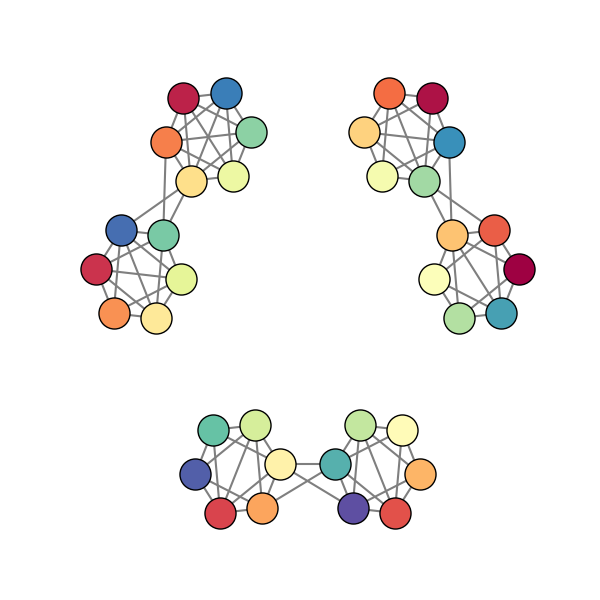

In [159]:
G=create_primary_graph(x_array,y_array,distance_criteria=4)
fig, ax = plt.subplots()
plot_communities(G, ax, dim=2)

# Plotting

This function colors the nodes in the graph to a user defined color map as a function of community ID.  The minimum and maximum ID's are used to normalize the spread of the cluster ID numbers across the maximum color gradient length.

A set of line segment are also added to visualize the edges in the graph.

Initially, each node has a unique community ID, and so the first graph shows node associations.

# Community Partition

The community partition value to be maximized is given by the product of the graph modularity and a delta function. The graph modularity $X$ is given by the following equation.

$X=\frac{1}{2m}\sum_{ij}{[A_{ij}-\frac{k_ik_j}{2m}]}$ where

$A_{ij}$ is the weight of the edge between $i$ and $j$

$k_i=\sum_jA_{ij}$ is the sum of weights of edges to $i$

$m=\frac{1}{2}\sum_{ij}A_{ij}$

The community partition function Q is then 

$Q=X\delta(c_i,c_j)$ where

$\delta$ is the delta function of $c_i,c_j$ where

$c_i$ is the community of $i$

The following function calculates the community partion for a given graph.

In [57]:
#calculate  Q
def calcQ(graph: "networkx.classes.graph.Graph"):
    X=pd.DataFrame(nx.modularity_matrix(graph))
#     print(X)
    Q=0
    for index_i, node_i in enumerate(graph.nodes()):
        for index_j, node_j in enumerate(graph.nodes()):
            if (graph.nodes[node_i]['community_ID']==graph.nodes[node_j]['community_ID']):
                delta_c=1
            if (graph.nodes[node_i]['community_ID']!=graph.nodes[node_j]['community_ID']):
                delta_c=0
            X[index_i][index_j]*=delta_c
            Q+=X[index_i][index_j]
    
    Q/=2*len(graph.edges())
    return Q

# Maximize Q

In first phase of the community partition maximization, nodes are moved to new communitites and the a new partition function is calculated.  If the new Q is greater than the previous value the move to the new community is accepted.  This is performed iteratively over all nodes until the value of Q no longer changes.

In this function, an initial plot of the graph is made, and upon successful movement of a node to a new community, the graph node color and community ID are updated to reflect the change.  At the end of this process the first level of communities are defined, but the larger communities of communities have still not been successfully grouped together.

In [60]:
def phase1(graph: "networkx.classes.graph.Graph"):
    
    convergedQ='NA'
    Q=calcQ(graph)

    while convergedQ != Q:
        convergedQ=Q
        for node in graph.nodes():
            for edge in nx.neighbors(graph,node):
                original_community_ID=graph.nodes[node]['community_ID']
                new_communityID=graph.nodes[edge]['community_ID']
                if graph.nodes[node]['community_ID']!=new_communityID:
                    graph.nodes[node]['community_ID']=new_communityID
                    graph.nodes[node]['community_ID']=graph.nodes[edge]['community_ID']
                    newQ=calcQ(graph)
                    if (newQ<=Q):
                        graph.nodes[node]['community_ID']=original_community_ID
                    if (newQ>Q):
                        Q=newQ
    return graph

In [78]:
H = copy.deepcopy(G)
H = phase1(H)

<IPython.core.display.Javascript object>


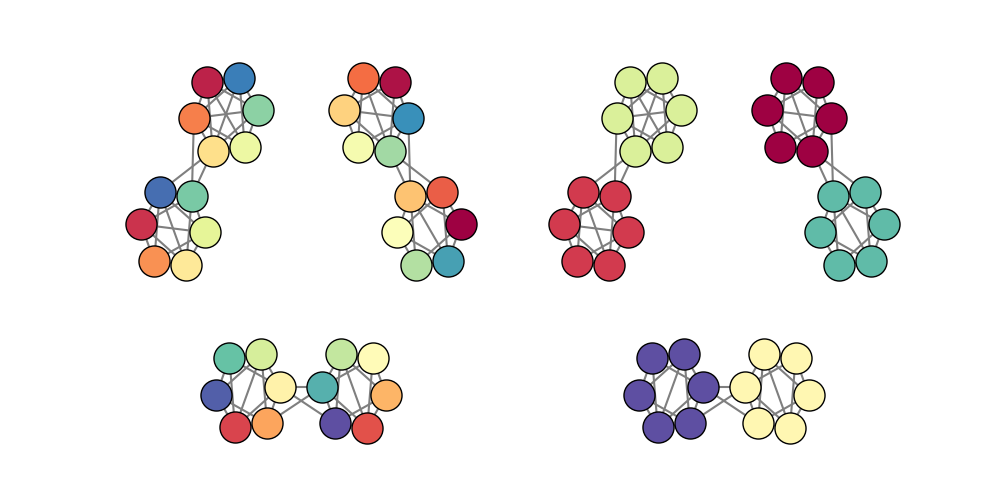

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

plot_communities(G, ax1, dim=2)
plot_communities(H, ax2, dim=2)

# Graph of Super Communities

To find the super communities, a new graph is made in which each node represents a community from the primary graph. These nodes have attributes associated with their community ID and a list of the node numbers in the primary graph that belong to this community ID.

The edges between these new nodes are given by the sum of the weights of the edges between primary graph node members between two communities. 

In [99]:
def create_super_graph(primary_graph: "networkx.classes.graph.Graph"): 

    super_graph = nx.Graph()

    #Initialize new graph with node ID's as the clusters from the original graph
    for node in primary_graph.nodes():
        super_graph.add_node(primary_graph.nodes[node]['community_ID'],
            community_ID = primary_graph.nodes[node]['community_ID'],
            community_members = [],
            coords = [0,0]
#             color = primary_graph.nodes[node]['color']
            )

    #Populate each cluster with list of original node members
    for node in primary_graph.nodes():
        super_graph.nodes[primary_graph.nodes[node]['community_ID']]['community_members'].append(node)

    #Set super node positions as average cartesian coordinates of primary graph node members
    for super_node in super_graph.nodes():
        sum_x=0
        sum_y=0
        for primary_node in super_graph.nodes[super_node]['community_members']:
            sum_x+=primary_graph.nodes[primary_node]['coords'][0]
            sum_y+=primary_graph.nodes[primary_node]['coords'][1]
        super_graph.nodes[super_node]['coords'][0]=sum_x/len(super_graph.nodes[super_node]['community_members'])
        super_graph.nodes[super_node]['coords'][1]=sum_y/len(super_graph.nodes[super_node]['community_members'])
        
#     Find edges between all super graph nodes representing primary graph clusters
#     and weight by sum of edge weights connecting nodes between the primary graph clusters
    for node in primary_graph.nodes():
        for neighbor in (nx.neighbors(primary_graph,node)):
            node_community = primary_graph.nodes[node]['community_ID']
            neigbor_community = primary_graph.nodes[neighbor]['community_ID']
            if node_community != neigbor_community:
                super_graph.add_edge(node_community,neigbor_community, weight = 0)
                super_graph.edges[node_community, neigbor_community]['weight'] += (
                 primary_graph.edges[node,neighbor]['weight'])
                
    return super_graph

<IPython.core.display.Javascript object>


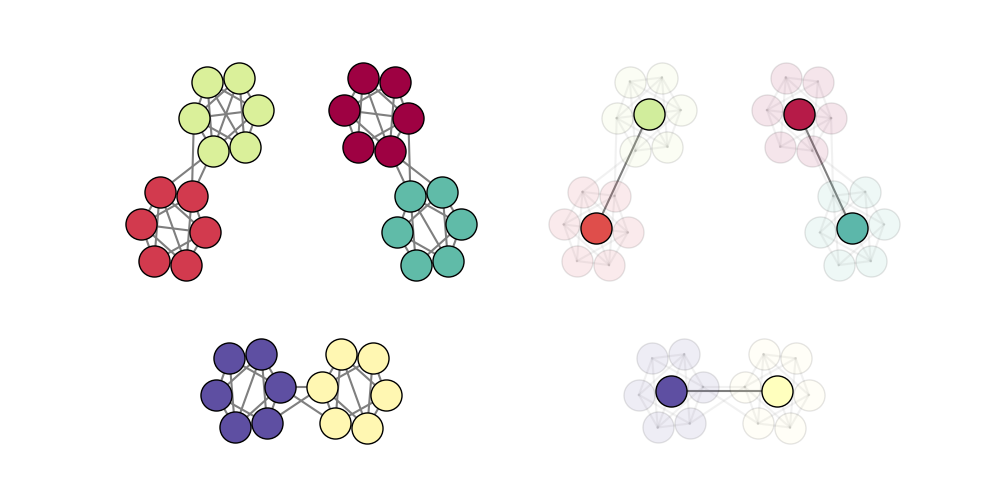

In [163]:
sH=create_super_graph(H)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plot_communities(H, ax1, dim=2)
plot_communities(H, ax2, dim=2, alpha=0.1)
plot_communities(sH, ax2, dim=2)

# 

In [167]:
def phase2(primary_graph, super_graph):
    
    original_community_ID=0
    new_community_ID=0

    convergedQ='NA'
    Q=calcQ(super_graph)
    while convergedQ != Q:
        convergedQ=Q
        for node in super_graph.nodes():
            for neighbor in nx.neighbors(super_graph,node):
                original_community_ID=super_graph.nodes[node]['community_ID']
                new_community_ID=super_graph.nodes[neighbor]['community_ID']
#                 print(original_community_ID, new_community_ID)

                if super_graph.nodes[node]['community_ID']!=new_community_ID:
                    super_graph.nodes[node]['community_ID']=new_community_ID
                    super_graph.nodes[node]['community_ID']=super_graph.nodes[neighbor]['community_ID']
                    newQ=calcQ(super_graph)
                    if (newQ<=Q):
                        super_graph.nodes[node]['community_ID']=original_community_ID
                    if (newQ>Q):
                        Q=newQ
                        
                        #update communities in lowest level graph
                        for community_member in super_graph.nodes[node]['community_members']:
                            primary_graph.nodes[community_member]['community_ID']=super_graph.nodes[neighbor]['community_ID']
                        
#                         yield(node, new_community_ID);

    return super_graph

<IPython.core.display.Javascript object>


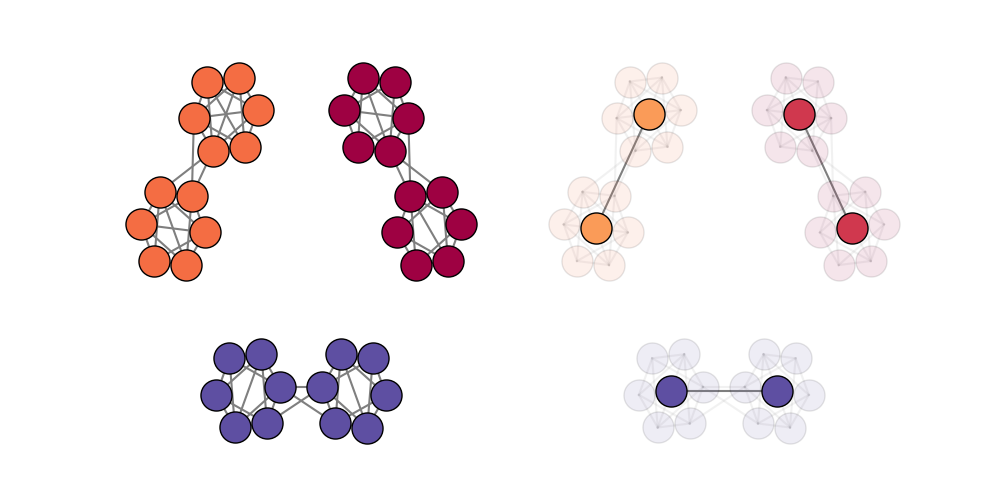

In [168]:
K = copy.deepcopy(H)
sK = copy.deepcopy(sH)

sK = phase2(K, sK)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plot_communities(K, ax1, dim=2)
plot_communities(K, ax2, dim=2, alpha=0.1)
plot_communities(sK, ax2, dim=2)

# Chemical Systems

In [169]:
def get_deltaQ(graph: "networkx.classes.graph.Graph", select_node, community_ID):

    ki=0        #sum of the weights of the links incident to node i
    kiin=0      #sum of the weights of the links from i to nodes in a community
    sumIn=0     #sum of weights of edges inside community
    sumTot=0    #sum weights of the links inicident to nodes in community
    m=0         #sum of weights of all edges in network
    
    for index, edge in enumerate(graph.edges(select_node,data=True)):
        ki+=(edge[2]['weight'])
        
        if (graph.nodes[edge[1]]['community_ID'] == community_ID):
            kiin+=(edge[2]['weight'])
            
    #get list of all edges within and incident to community
    edgeList = deque()
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']==community_ID:
            for index, edge in enumerate(graph.edges(node,data=True)):
                sorted_edge=sorted((edge[0],edge[1]))
                sorted_edge.append(edge[2]['weight'])
                edgeList.append(tuple(sorted_edge))
                edgeList = list(set(edgeList))  #remove duplicates

    for edge in edgeList:
        if (graph.nodes[edge[0]]['community_ID'] == community_ID
            and graph.nodes[edge[1]]['community_ID'] == community_ID):
            sumIn+=edge[2]
        if (graph.nodes[edge[0]]['community_ID'] != community_ID
            or graph.nodes[edge[1]]['community_ID'] != community_ID):
            sumTot+=edge[2]
    
    for u, v, weight in graph.edges.data('weight'):
        m+=weight

    
    deltaQ=((sumIn+kiin)/2/m-((sumTot+ki)/2/m)**2)-(sumIn/2/m-(sumTot/2/m)**2-(ki/2/m)**2)

    return deltaQ

In [170]:
def phase1_dQ(graph: "networkx.classes.graph.Graph"):

    community_list=list(nx.get_node_attributes(graph,'community_ID').values())
    deltaQ_increasing=True
    
    while deltaQ_increasing == True:
        deltaQ_increasing=False
        for node in graph.nodes():
            original_community_ID=graph.nodes[node]['community_ID']
            new_community_ID=original_community_ID

            #place node in new isolated community
            graph.nodes[node]['community_ID']=len(graph.nodes())
            deltaQ=get_deltaQ(graph,node,new_community_ID)
            
            for community_ID in community_list:
                deltaQ_new=get_deltaQ(graph,node,community_ID)
                if deltaQ_new > deltaQ:
                    deltaQ=deltaQ_new
                    new_community_ID=community_ID
#                     yield new_community_ID
                    
            #move node back to original community if no better community was found
            graph.nodes[node]['community_ID']=new_community_ID

            #if a node has changed communities, loop through all nodes again 
            if original_community_ID != new_community_ID:
                deltaQ_increasing=True
                
    return graph

In [193]:
def phase1_dQ_fast(graph: "networkx.classes.graph.Graph"):

    community_list=list(nx.get_node_attributes(graph,'community_ID').values())
    deltaQ_increasing=True
    
    while deltaQ_increasing == True:
        deltaQ_increasing=False
        for node in graph.nodes():
            original_community_ID=graph.nodes[node]['community_ID']
            new_community_ID=original_community_ID

            #place node in new isolated community
            graph.nodes[node]['community_ID']=len(graph.nodes())
            deltaQ=get_deltaQ(graph,node,new_community_ID)
            
            for neighbor in nx.neighbors(graph,node):
                neighbor_community_ID=graph.nodes[neighbor]['community_ID']
                
            
#             for community_ID in community_list:
                deltaQ_new=get_deltaQ(graph,node,neighbor_community_ID)
                if deltaQ_new > deltaQ:
                    deltaQ=deltaQ_new
                    new_community_ID=neighbor_community_ID
#                     yield new_community_ID
                    
            #move node back to original community if no better community was found
            graph.nodes[node]['community_ID']=new_community_ID

            #if a node has changed communities, loop through all nodes again 
            if original_community_ID != new_community_ID:
                deltaQ_increasing=True

    return graph

In [195]:
import time

# H1 = copy.deepcopy(G)
# start_time=time.time()
# H1=phase1(H1)
# print("Matrix Modularity Method: " + str(round(time.time()-start_time,2)) + " seconds")
 
H1 = copy.deepcopy(G)
start_time=time.time()
H1=phase1_dQ(H1)
print("deltaQ Method: " + str(round(time.time()-start_time,2)) + " seconds")

H1 = copy.deepcopy(G)
start_time=time.time()
H1=phase1_dQ_fast(H1)
print("deltaQ Neighbors Method: " + str(round(time.time()-start_time,2)) + " seconds")
 

deltaQ Method: 0.66 seconds
deltaQ Neighbors Method: 0.17 seconds


In [229]:
#import Gromacs data

def get_GROMACS_XYZ_data(timestep, filePath):
    header_df = pd.read_csv(filePath, sep=' ', nrows=2, header=None)
    numAtoms=int(header_df.loc[1, 0])
    headerRows=2
    rowStart = (timestep)*numAtoms+(timestep+1)*headerRows
    timestep_df = pd.read_csv(filePath, delim_whitespace=True, skiprows=rowStart, nrows=numAtoms, header=None, usecols=[1,3,4,5])
    timestep_df.columns = ['AtomType','x_coord','y_coord', 'z_coord']
    #     timestep_df.columns = ['AtomLabel','AtomType','AtomNumber','x_coord','y_coord', 'z_coord','x','y','z']
    return timestep_df



In [303]:
def get_timestep(timestep, filePath):
    timestep_df = get_GROMACS_XYZ_data(timestep, filePath)

    #remove majority A atoms
    timestep_df = timestep_df[~timestep_df['AtomType'].str.contains("B")]
    timestep_df = timestep_df[timestep_df['x_coord'] <= 2]
    timestep_df = timestep_df[timestep_df['y_coord'] <= 2]
    timestep_df = timestep_df[timestep_df['z_coord'] <= 2]
    timestep_df = timestep_df.reset_index(drop=True)
    return timestep_df
#     print(timestep_df)

In [313]:
print("This is number " + str(1))

This is number 1


<IPython.core.display.Javascript object>


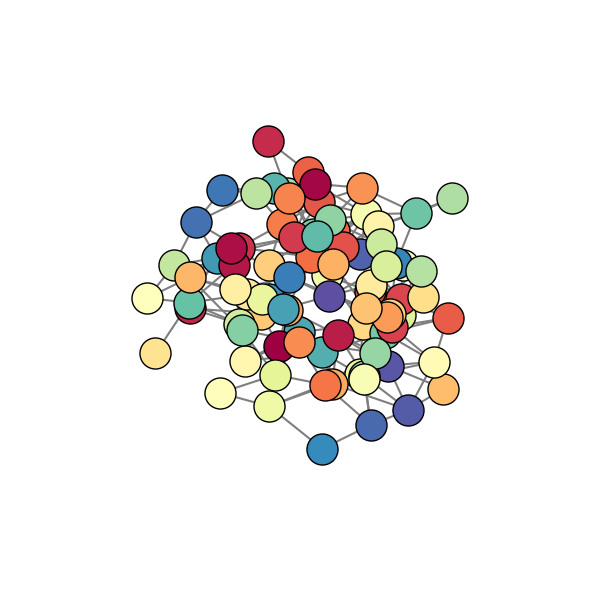

In [247]:
filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/notebooks/chapter7/data/sys_001_npt.gro"
timestep_00_df = get_timestep(0,filePath)

LJ=create_primary_graph(
    timestep_00_df['x_coord'].values,
    timestep_00_df['y_coord'].values,
    timestep_00_df['z_coord'].values,
    distance_criteria=0.6)

fig, ax = plt.subplots()
plot_communities(LJ, ax, dim=3)

In [245]:
LJH = copy.deepcopy(LJ)
start_time=time.time()
LJH=phase1_dQ(LJH)
print("deltaQ Method: " + str(time.time()-start_time) + " seconds")

LJH = copy.deepcopy(LJ)
start_time=time.time()
LJH=phase1_dQ_fast(LJH)
print("deltaQ Neighbors Method: " + str(time.time()-start_time) + " seconds")

deltaQ Method: 14.3375723361969 seconds
deltaQ Neighbors Method: 3.3946752548217773 seconds


<IPython.core.display.Javascript object>


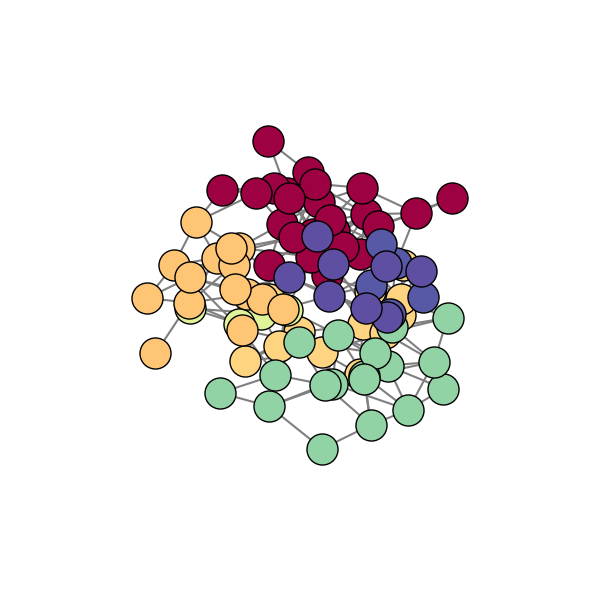

In [246]:
fig, ax = plt.subplots()
plot_communities(LJH, ax, dim=3)

In [304]:
#assign community id from current timestep to next timestep
LJ = [] 

filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/notebooks/chapter7/data/sys_001_npt.gro"
timestep_00_df = get_timestep(0,filePath)


LJ.append(create_primary_graph(
    timestep_00_df['x_coord'].values,
    timestep_00_df['y_coord'].values,
    timestep_00_df['z_coord'].values,
    distance_criteria=0.6))

start_time=time.time()
LJ[0]=phase1_dQ_fast(LJ[0])
print("Snapshot 0: " + str(time.time()-start_time) + " seconds")

# fig, ax = plt.subplots()
# plot_communities(LJ[0], ax, dim=3)
for i in range(8):
    i+=1
    filePath="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/notebooks/chapter7/data/sys_00" + str(i) + "_npt.gro"
    timestep_df = get_timestep(0,filePath)

    LJ.append(create_primary_graph(
        timestep_df['x_coord'].values,
        timestep_df['y_coord'].values,
        timestep_df['z_coord'].values,
        distance_criteria=0.6))
    
    for node in LJ[i].nodes():
        LJ[i].nodes[node]['community_ID']=LJ[i-1].nodes[node]['community_ID']
        
    start_time=time.time()
    LJ[i]=phase1_dQ_fast(LJ[i])
    print("Snapshot " + str(i) + ": " + str(time.time()-start_time) + " seconds")



Snapshot 0: 3.379706621170044 seconds
Snapshot 1: 0.8698890209197998 seconds
Snapshot 2: 0.3289515972137451 seconds


KeyError: 40

<IPython.core.display.Javascript object>


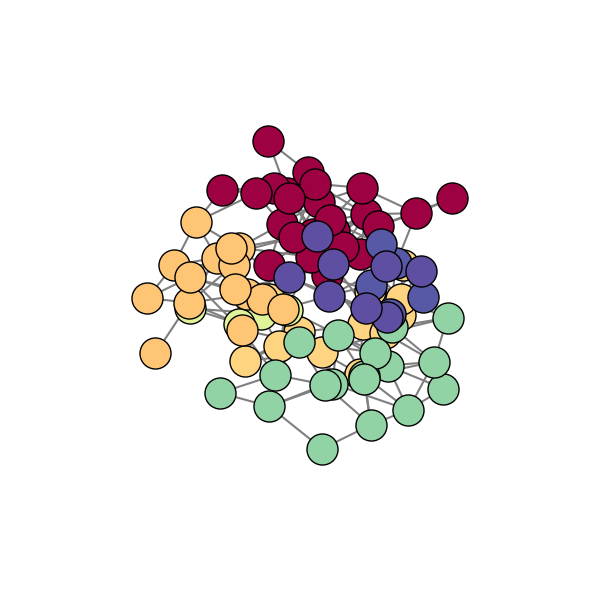

<IPython.core.display.Javascript object>


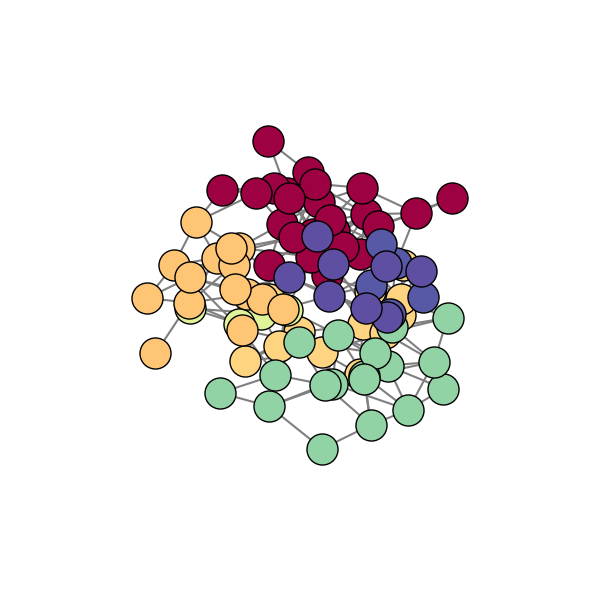

In [306]:
for i in range(2):
    fig, ax = plt.subplots()
    plot_communities(LJ[i], ax, dim=3)

In [279]:
LJ[0].nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85))

In [ ]:
create_super_graph()

In [ ]:
def create_super_graph(primary_graph): 

    super_graph = nx.Graph()

    #Initialize new graph with node ID's as the clusters from the original graph
    for node in primary_graph.nodes():
        super_graph.add_node(H.nodes[node]['community_ID'],
            community_ID = primary_graph.nodes[node]['community_ID'],
            community_members = [],
            color = primary_graph.nodes[node]['color']
            )

    #Populate each cluster with list of original node members
    for node in primary_graph.nodes():
        super_graph.nodes[primary_graph.nodes[node]['community_ID']]['community_members'].append(node)


    #Find edges between clusters and weight by sum of the two clusters
    for node in primary_graph.nodes():
        for neighbor in (nx.neighbors(primary_graph,node)):
            node_community = primary_graph.nodes[node]['community_ID']
            neigbor_community = primary_graph.nodes[neighbor]['community_ID']
            if node_community != neigbor_community:
                super_graph.add_edge(node_community,neigbor_community, weight = 0)
                super_graph.edges[node_community, neigbor_community]['weight'] += (
                 primary_graph.edges[node,neighbor]['weight'])
                
    return super_graph

H1= copy.deepcopy(H)
super_graph = create_super_graph(H1)


In [ ]:
LJ.nodes[1]

In [ ]:
colorNodes(LJH)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_axis_off()


for node in LJH.nodes():
    ax.scatter(LJH.nodes[node]['x_coord'],
               LJH.nodes[node]['y_coord'],
               LJH.nodes[node]['z_coord'],
               color= LJH.nodes[node]['color'],
               s=500,
              depthshade=True)